# **Identification of fabricated data**

This document contains the source code for the work [Identification of fabricated interviewers in the SOEP survey](https://www.dropbox.com/s/wwteky0ehktwptl/IdentificationOfFabricatedInterviews.pdf?dl=1). The code is only loosely documented as most procedures are explained in the paper.    
The first part is plain Stata code which can be pasted into a standard do-file. The second part is written in Python where the processed Stata datasets are read-in and used for bootstrapping, supervised classification and visualization.   

# Part 1: Stata

```

**** Working Directories


	global fakedir "/D/Dropbox/kasus/workspace/stata/soepfake_raw" // Directory for Fake Datasets
	global soepdir "/D/Dropbox/kasus/workspace/stata/soep30"       // Directory for SOEP Datasets
	global outdir  "/D/Dropbox/kasus/workspace/stata/soepfake"     // Directory for Combined Datasets
	
	global fakedir "E:\Dropbox\kasus\workspace\stata\soepfake_raw" // Directory for Fake Datasets
	global soepdir "E:\Dropbox\kasus\workspace\stata\soep30"       // Directory for SOEP Datasets
	global outdir  "E:\Dropbox\kasus\workspace\stata\soepfake"     // Directory for Combined Datasets


*********************************************
* Combining Fake and Real Data              *
*********************************************

	****************** 1984  A ***************

	use "$fakedir/ap_f.dta", clear
	
	* ssc install fre (uncomment if not already installed)
	
	** checking missing values
	egen allmiss = rowmiss(_all)
	fre allmiss
	drop allmiss
	** between 179 and 210 out of 267 possible missing values
	
	
	merge m:1 hhnr using "$fakedir/hbru84_f.dta", keepusing(intnr) // getting interviewer nr
	rename intnr intid
	

	fre intid // checking interviewer nr

	gen fake = 1
	fre fake
	bysort persnr:  gen dup = cond(_N==1,0,_n)
	tab dup // persnr no unique identifier
	replace persnr = persnr + [_n]
	drop dup
	save "$outdir/1984A_fake.dta", replace


	use "$soepdir/ap.dta", clear
	merge 1:1 persnr using "$soepdir/apbrutto.dta", keepusing(intid) // getting interviewer nr
	drop if _merge !=3
	fre intid
	save "$outdir/1984A_clean.dta", replace


	append using "$outdir/1984A_fake.dta"
	replace fake = 0 if fake == .
	fre fake
	fre intid if fake==1
	save "$outdir/1984A_combined.dta", replace




	****************** 1998  E ***************

	use "$fakedir/op_f.dta", clear
	
	** checking missing values
	egen allmiss = rowmiss(_all)
	fre allmiss
	drop allmiss
	** between 320 and 412 out of 531 possible missing values
	
	rename opintnr intid
	fre intid // checking interviewer nr
	*drop if  inlist(intid, 236037, 236807, 249281) // dropping interviewer which are not 100% classified as fakers

	gen fake = 1
	fre fake
	bysort persnr:  gen dup = cond(_N==1,0,_n)
	tab dup // every persnr only appears once
	drop dup
	save "$outdir/1998E_fake.dta", replace

	use "$soepdir/op.dta", clear
	save "$outdir/1998E1_clean.dta", replace


	append using "//D/Dropbox/kasus/workspace/stata/soepfake/1998E_fake.dta"
	replace fake = 0 if fake == .
	fre fake
	fre intid if fake==1
	save "$outdir/1998E_combined.dta", replace


	****************** 1999  E *************

	use "$fakedir/pp_f.dta", clear
	
	** checking missing values
	egen allmiss = rowmiss(_all)
	fre allmiss
	drop allmiss
	** between 297 and 347 out of 477 possible missing values
	
	
	rename ppintnr intid
	fre intid // checking interviewer nr

	gen fake = 1
	fre fake
	bysort persnr:  gen dup = cond(_N==1,0,_n)
	tab dup // every persnr only appears once
	drop dup
	save "$outdir/1999E_fake.dta", replace

	use "$soepdir/pp.dta", clear
	save "$outdir/1999E_clean.dta", replace


	append using "$outdir/1999E_fake.dta"
	replace fake = 0 if fake == .
	fre fake
	fre intid if fake==1
	save "$outdir/1999E_combined.dta", replace



	************ 2000 F ***************************



	use "$fakedir/qp_f.dta", clear
	
	** checking missing values
	egen allmiss = rowmiss(_all)
	fre allmiss
	drop allmiss
	** between 413 and 457 out of 552 possible missing values
	
	rename qpintnr intid
	fre intid // checking interviewer nr

	gen fake = 1
	fre fake
	bysort persnr:  gen dup = cond(_N==1,0,_n)
	tab dup // every persnr only appears once
	drop dup
	save "$outdir/2000F_fake.dta", replace

	use "$soepdir/qp.dta", clear
	save "$outdir/2000F_clean.dta", replace


	append using "$outdir/2000F_fake.dta"
	replace fake = 0 if fake == .
	fre fake
	fre intid if fake==1
	save "$outdir/2000F_combined.dta", replace



*************************************************
* Checking Datasets and Extracting First Digits * 
*************************************************
	
	**********
	**** 1984
	
	use "$outdir/1984A_combined.dta", clear
	fre fake
	fre intid if fake == 1
	drop  _merge aisco atreiman awegener aiscou aiscoh abranche 
	
	mvdecode _all, mv(-1 = .a \  -2 = .b \  -3 = .c) 
	egen allmiss = rowmiss(_all)
	bysort fake: sum allmiss
	
	bysort intid: gen n_ints = _n == 1
	count if n_ints
	
	bysort intid: gen n_counter = _N
	
	
	** Variance
	#delimit ;
	foreach x of varlist ap0101 - ap6803 { ;
	gen var_`x' = .;
	sum `x';
	replace var_`x' = r(Var) if !mi(`x') ;
	} ;	
	
	egen var_count = rownonmiss(var_*)
	
	** Extracting First Digits
	#delimit ;
	foreach x of varlist ap2202 ap3301 ap3302 ap3402 ap3403 ap3501 ap3904 ap3906 ap3908 ap3910 
	ap4002 ap4004 ap4307 ap4308 ap4404 ap4405 ap46a02 ap46b02 ap46b03 ap46b04 ap46b05 ap4702 
	ap4704 ap4706 ap4708 ap4710 ap47a02 ap47a03 ap47a04 ap47a05 ap47b03 ap5013 ap5103 ap5202
	{;
		replace `x' = . if `x' == 0;
		tostring `x', gen(fd_`x');
		replace fd_`x' = substr(fd_`x', 1, 1);
		destring fd_`x', replace;
		};		

	 ** Extreme Categories
	 #delimit ;
	 foreach x of varlist ap0201 ap0202 ap0203 ap0204 ap0205 ap0206 
	 ap0301 ap0302 ap0303 ap0304 ap0305 ap0306 ap48 ap5401 ap5402 
	 ap5403 ap5404 ap5405 ap5603 ap6801 ap6802 ap6803 {;
	 gen minmax_`x' = .;
	 replace minmax_`x' = 0 if !mi(`x');
	 sum `x';
	 replace minmax_`x' = 1 if `x' == r(min) | `x' == r(max);
	 };
	
	#delimit cr
	
	egen variance = rsum(var_*)
	bysort fake: sum variance
	
	egen c0 = anycount(minmax*), values(0)
	egen extremes = rsum(minmax*)
	gen extreme_perc = extremes / (c0 + extremes)
	bysort fake: sum extreme_perc
	#delimit cr
	order fd_*, last
	save "$outdir/1984A_combined.dta", replace
	 


	*********
	**** 1998
	
	use  "$outdir/1998E_combined.dta", clear
	keep if inrange(sample1, 10, 11)
	fre fake
	fre intid if fake == 1
	drop oisco otreiman owegener oisei oiscou oiscoh oisco88 otreim88 oisei88 oiscon otreimn owegenn ///
	oisein oiscoun oiscohn oisco88n otrei88n oisei88n obranche obranchb op28_is88 op28_klas op31_nace op47a_is88n op47a_klasn ///
	op5701 op5702 op5703 op5704 op5705 op5706 op5707 op5708 op5709 op5710 
	
	mvdecode _all, mv(-1 = .a \  -2 = .b \  -3 = .c) 
	egen allmiss = rowmiss(_all)
	bysort fake: sum allmiss

	
	bysort intid: gen n_ints = _n == 1
	count if n_ints
	
	bysort intid: gen n_counter = _N
	
	

	
	
	** Variance
	#delimit ;
	foreach x of varlist op0101 - op12302  {;
	gen var_`x' = .;
	sum `x';
	replace var_`x' = r(Var) if !mi(`x')  ;
	};
	
	egen var_count = rownonmiss(var_*)
	
	** Extracting First Digits
	#delimit ;
	foreach x of varlist op1801 op4501 op4502 op4801 op4802 op4902 op4904 op4906 op4908 op4910 
	op4912 op4914 op4916 op4918 op4920 op4922 op5602 op58a03 op58b03 op58c03 op58d03 op58e03 
	op58f03 op58g03 op58h03 op58i03 op58j03 op58k03 op58l03 op58m03 op5902 op5904 op5906 
	op5908 op5910 op5912 op6101 op6102 op6103 op6104 op6105 op6106 op6107 op6108 op6109 
	op6110 op6111 op6112 op6113 op6114 op6115 op6116 op6117 op6118 op6309 op6312 op12206 op12210 op12218 {;
		replace `x' = . if `x' == 0;
		tostring `x', gen(fd_`x');
		replace fd_`x' = substr(fd_`x', 1, 1);
		destring fd_`x', replace;
		};		


	
	** Generating 2nd variable selection variant
	#delimit ;
	foreach x of varlist  op1801 op2202	op4401	op4501	op4502	op4801	op4802	op4902	op4904	op4906	op4908	
	op4910	op4912	op4914	op4916	op4918	op4920	op4922	op5602	op58a03	op58b03	op58c03	op58d03
	op58e03	op58f03	op58g03	op58h03	op58i03	op58j03	op58k03	op58l03	op58m03	op5902	op5904	op5906	
	op5908	op5910	op5912	op6101	op6102	op6103	op6104	op6105	op6106	op6107	op6108	op6109	
	op6110	op6111	op6112	op6113	op6114	op6115	op6116	op6117	op6118	op6309	op6312	op7002	
	op7101	op7202	op7203	op9001	op9101	op9102	op9301	op9302	op9303	op9304	op12202	op12206	op12210	op12218 {;
		replace `x' = . if `x' == 0;
		tostring `x', gen(sch_`x');
		replace sch_`x' = substr(sch_`x', 1, 1);
		destring sch_`x', replace;
		};		
	
	#delimit cr
	egen test = anycount(sch_*), values(0 1 2 3 4 5 6 7 8 9)
	fre test if intid == 236837
		** 200 Digits when accounting for 0 values AND non monetary variables

	** Extreme Categories
	#delimit ;
	foreach x of varlist op0101 op0102 op0103 op0104 op0105 op0106 op0107 op0108 op0109 op0110 op0111 
	op0601 op0602 op0603 op0604 op0605 op0606 op0607 op0608 op0609 op0610 op0611 op0612 
	op0613 op0614 op0615 op0616 op0801 op0802 op0803 op0804 op0805 op0806 op0807 op0808 
	op0809 op0810 op0811 op0812 op0813 op2401 op2402 op2403 op2404 op2405 op2406 op2407 
	op2408 op25 op66 op67 op9201 op9202 op9203 op9204 op9205 op9206 op9207 op9208 op9209
	op9501 op9502 op9504 op96 op9703 op9801 op9802 op9803 op9804 op9805 
	op9806 op9807 op9808 op9809 op9810 op12301 op12302 {;
	 gen minmax_`x' = .;
	 replace minmax_`x' = 0 if !mi(`x');
	 sum `x';
	 replace minmax_`x' = 1 if `x' == r(min) | `x' == r(max);
	 };
	
	#delimit cr
	
	
	
	egen variance = rsum(var_*)
	bysort fake: sum variance
	
	
	egen c0 = anycount(minmax*), values(0)
	egen extremes = rsum(minmax*)
	gen extreme_perc = extremes / (c0 + extremes)
	bysort fake: sum extreme_perc


	order fd_*, last
	save  "$outdir/1998E_combined.dta", replace
	
	
	*********
	**** 1999

	use  "$outdir/1999E_combined.dta", clear
	keep if inrange(sample1, 10, 11)
	fre fake
	fre intid if fake == 1
	drop pisco piscou piscoh ptreiman pwegener pisei pisco88 ptreim88 pisei88 piscon ///
	piscoun piscohn ptreimn pwegenn pisein piscon88 ptrei88n pisei88n pbranche pbranchb ///
	pp29_is88 pp29_klas pp34_nace pp62_is88n pp62_klasn pp7501 pp7502 pp7503 ///
	pp7504 pp7505 pp7506 pp7507 pp7508 pp7509 pp7510 
	
	
	mvdecode _all, mv(-1 = .a \  -2 = .b \  -3 = .c) 
	egen allmiss = rowmiss(_all)
	bysort fake: sum allmiss

	
	bysort intid: gen n_ints = _n == 1
	count if n_ints
	
	bysort intid: gen n_counter = _N

	
	** Variance
	#delimit ;
	foreach x of varlist pp0101 - pp136 {;
	gen var_`x' = .;
	sum `x';
	replace var_`x' = r(Var) if !mi(`x')  ;
	};
	
	egen var_count = rownonmiss(var_*)
	
	
	** Extracting First Digits
	#delimit ;
	foreach x of varlist pp1801 pp4501 pp6001 pp6002 pp6602 pp6604 pp6606 pp6608 pp6610 pp6612 
	pp6614 pp6616 pp6618 pp6620 pp6622 pp6624 pp7302 pp76a03 pp76b03 pp76c03 pp76d03 pp76e03 
	pp76f03 pp76g03 pp76h03 pp76i03 pp76j03 pp76k03 pp76l03 pp76m03 pp7702 pp7704 pp7706 pp7708
	pp7710 pp7712 pp7901 pp7902 pp7903 pp7904 pp7905 pp7906 pp7907 pp7908 pp7909 pp7910 pp7911 
	pp7912 pp7913 pp7914 pp7915 pp7916 pp7917 pp7918 pp8401 pp9001 pp13402 pp13406 pp13410 pp13414 pp13418 {;
		replace `x' = . if `x' == 0;
		tostring `x', gen(fd_`x');
		replace fd_`x' = substr(fd_`x', 1, 1);
		destring fd_`x', replace;
		};		


	** Extreme Categories
	#delimit ;
	foreach x of varlist pp0101 pp0102 pp0103 pp0104 pp0105 pp0106 pp0107 pp0108 pp0109 pp0110 pp0111 
	pp0301 pp0302 pp0303 pp0304 pp0305 pp0306 pp0307 pp0308 pp0401 pp0402 pp0403 
	pp0404 pp0405 pp0406 pp0407 pp0408 pp0409 pp0410 pp0411 pp0412 pp0413 pp2501 
	pp2502 pp2503 pp2504 pp2505 pp2506 pp2507 pp2508 pp26 pp42 pp10701 pp10702 
	pp10703 pp10704 pp10705 pp10706 pp10707 pp10708 pp10709 pp10710 pp108 pp10901 
	pp10902 pp10903 pp10904 pp10905 pp10906 pp10907 pp10908 pp10909 pp10910 pp110 pp11202 pp13501 pp13502 pp136 {;
	 gen minmax_`x' = .;
	 replace minmax_`x' = 0 if !mi(`x');
	 sum `x';
	 replace minmax_`x' = 1 if `x' == r(min) | `x' == r(max);
	 };
	#delimit cr
	
	egen variance = rsum(var_*)
	bysort fake: sum variance
	
	
	egen c0 = anycount(minmax*), values(0)
	egen extremes = rsum(minmax*)
	gen extreme_perc = extremes / (c0 + extremes)
	bysort fake: sum extreme_perc

	
	order fd_*, last
	save  "$outdir/1999E_combined.dta", replace
	
	
	
	*********
	**** 2000
	
	use  "$outdir/2000F_combined.dta", clear
	keep if inrange(sample1, 12, 13)
	fre fake
	fre intid if fake == 1
	drop qisco qiscou qiscoh qtreiman qwegener qisei qisco88 qtreim88 qisei88 qiscon qiscoun qiscohn ///
	qtreimn qwegenn qisein qiscon88 qtrei88n qisei88n qbranche qbranchb iisco00 istab00 iiscon00 istabn00 inace00 ///
	qp27_is88 qp27_klas qp32_nace qp58_is88n qp58_klasn qp3703 qp3704 qp3705  

	mvdecode _all, mv(-1 = .a \  -2 = .b \  -3 = .c) 
	egen allmiss = rowmiss(_all)
	bysort fake: sum allmiss

	
	bysort intid: gen n_ints = _n == 1
	count if n_ints
	
        bysort intid: gen n_counter = _N

	** First Digits for Monetary Values
	lookfor verdienst gehalt betr
	display r(varlist)
	ds qp0107 qp05a4 qp2302 qp2307 qp3002 qp31 qp5601 qp5602 qp5701 qp6301 qp6302 qp6304 qp6306 qp6308 ///
	qp6310 qp6312 qp6314 qp6316 qp6318 qp6320 qp6322 qp6324 qp6602 qp6606 qp6610 qp6614 qp6618 qp7301 ///
	qp7302 qp76a03 qp76a04 qp76c03 qp76d03 qp76e03 qp76f03 qp76g03 qp76h03 qp76i03 qp76j03 qp76k03 qp76l03 ///
	qp76m03 qp7701 qp7702 qp7703 qp7704 qp7706 qp7708 qp7710 qp7712 qp7901 qp7902 qp7903 qp7904 qp7905 qp7906 ///
	qp7907 qp7908 qp7909 qp7910 qp7911 qp7912 qp7913 qp7914 qp7915 qp7916 qp7917 qp7918 qp10903 qp114, has(type int long) // keeping only numeric variables
	
	** qp5601   qp6306   qp6314   qp6322   qp6610   qp76a03  qp76e03  qp76i03  qp76m03  qp7708   qp7902   qp7906   qp7910   qp7914   qp7918
	** qp5602   qp6308   qp6316   qp6324   qp6614   qp76a04  qp76f03  qp76j03  qp7702   qp7710   qp7903   qp7907   qp7911   qp7915
	** qp6302   qp6310   qp6318   qp6602   qp6618   qp76c03  qp76g03  qp76k03  qp7704   qp7712   qp7904   qp7908   qp7912   qp7916
	** qp6304   qp6312   qp6320   qp6606   qp7302   qp76d03  qp76h03  qp76l03  qp7706   qp7901   qp7905   qp7909   qp7913   qp7917


	
	** Variance
	#delimit ;
	foreach x of varlist qp0101 - qp144 {;
	gen var_`x' = .;
	sum `x';
	replace var_`x' = r(Var) if !mi(`x')  ;
	};
	
	
	egen var_count = rownonmiss(var_*)
	
	
	** Extracting First Digits
	
	#delimit ;
	
	foreach x of varlist qp5601 qp6306 qp6314 qp6322 qp6610 qp76a03 qp76e03 qp76i03 qp76m03 qp7708 
	qp7902   qp7906   qp7910   qp7914   qp7918 qp5602   qp6308   qp6316   qp6324   qp6614   qp76a04  qp76f03  qp76j03 
	qp7702   qp7710   qp7903   qp7907   qp7911   qp7915 qp6302   qp6310   qp6318   qp6602   qp6618   qp76c03  qp76g03 
	qp76k03  qp7704   qp7712   qp7904   qp7908   qp7912   qp7916 qp6304   qp6312   qp6320   qp6606   qp7302   qp76d03 
	qp76h03  qp76l03  qp7706   qp7901   qp7905   qp7909   qp7913   qp7917 {;
		replace `x' = . if `x' == 0;
		tostring `x', gen(fd_`x');
		replace fd_`x' = substr(fd_`x', 1, 1);
		destring fd_`x', replace;
		};		

	** Extreme Categories
	#delimit ;
	foreach x of varlist qp0101 qp0102 qp0103 qp0104 qp0105 qp0106 qp0107 qp0108 qp0109 qp0110 
	qp0111 qp2303 qp2304 qp2305 qp2306 qp2307 qp2308 qp24 qp42 qp95 
	qp96 qp113 qp114 qp115 qp11702 qp11801 qp11802 qp11803 qp11804 qp11805 
	qp11806 qp11807 qp11808 qp11809 qp11810 qp11811 {;
	 gen minmax_`x' = .;
	 replace minmax_`x' = 0 if !mi(`x');
	 sum `x';
	 replace minmax_`x' = 1 if `x' == r(min) | `x' == r(max);
	 };
	#delimit cr
	
	
	egen variance = rsum(var_*)
	bysort fake: sum variance
	
	
	egen c0 = anycount(minmax*), values(0)
	egen extremes = rsum(minmax*)
	gen extreme_perc = extremes / (c0 + extremes)
	bysort fake: sum extreme_perc
	order fd_*, last
	
	
	save  "$outdir/2000F_combined.dta", replace


```

# Part 2: Python

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import math
import scipy
import time
import pickle
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3, style="whitegrid", color_codes=True) 
import statsmodels.api as sm
from IPython.display import display, clear_output
from collections import Counter
from __future__ import division
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.mixture import GMM
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import unbalanced_dataset
from unbalanced_dataset import SMOTETomek, CondensedNearestNeighbour, SMOTE

# Setting display options
pd.set_option('display.height', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

# Setting random seed for reproduction purposes
np.random.seed(1)

height has been deprecated.



In [3]:
# changing working directory
%cd /D/Dropbox/kasus/workspace/stata/soepfake

/D/Dropbox/kasus/workspace/stata/soepfake


# Analysis

### Defining Functions

In [4]:
def benford(digit):
    '''Calculating the Likelihood for a given digit
    to be the first digit based on Benford's Law'''

    return math.log10(1. + (1./digit))

In [6]:
def chi2_row(r):
    '''Calculating Chi Square based on the difference
    between the actual distribution of first digits and 
    the expected distribution according to Benford's Law'''
    
    numlist = r[range(4,13)].tolist()
    bflist=  r[range(15,24)].tolist()
    return stats.chisquare(numlist, bflist)[0]

In [7]:
def chi2_bootstrap(r):
    '''Bootstrapping Chi2 values p based on Benford's Law 
       and the number of observed first digits per Interviewer-Cluster. 
       Afterwards, probabilites for the observed chi2 values
       will be calculated by using the percentile interval method.
       CAUTION: RUNNING THIS FUNCTION MAY TAKE A LONG TIME'''
    
    print(r)
    
    # calculating chi2 for the interviewercluster
    numlist = r[range(4,13)].tolist()
    
    print("Numbers", numlist)
    print ("Sum Numbers", sum(numlist))
    
    bflist=  r[range(14,24)].tolist()
    
    print("Benford", bflist)
    
    chi = stats.chisquare(numlist, bflist)[0]
    
    print("Chi2 value", chi)
    
    # combining counts and digits
    ziplist = zip(numlist, range(1,10))
    bootlist = []
    for x, y in ziplist:
        for i in range(1, int(x)+1):
            bootlist.append(y)
            
    # Drawing 2000 bootstrap samples with n equal to observed number of digits per
    # interviewercluster
    chilist = []
    for n_ in range(0, 2000):
        sample = np.random.choice(fullboot, sum(numlist))
        freqs = Counter(sample)
        for i in range(1,10):
            if i not in freqs:
                freqs[i] = 0
        
        #print 'Boostrap dic', freqs
        agglist = []
        
        # calculating chi2 for bootstrap sample and expected benford distribution
        for d in range(1,10):
            agglist.append(freqs[d])
            
        #print 'Agglist', agglist
        #time.sleep(5)
        chilist.append(stats.chisquare(agglist, bflist)[0])
        
    # calculating probability of obtaining chi2 value more extreme than observed
    # by using percentile interval methods 
    perc = [val  for val in chilist if val < chi]
    pchi = 1- (len(perc) / len(chilist))
    
    print("number of chi2's < chi", len(perc))
    print("pchi", pchi)
    #print "Chi List", chilist
    
    clear_output(wait=True)
    #time.sleep(10)
    return pchi

In [6]:
def chi2_bootstrap_sv(r):
    
    '''Bootstrapping Chi2 values p based on the distribution of first digits in the survey
       and the number of observed first digits per Interviewer-Cluster. 
       Afterwards, probabilites for the observed chi2 values
       will be calculated by using the percentile interval method.
       CAUTION: RUNNING THIS FUNCTION MAY TAKE A LONG TIME'''
    
    print(r)
    
    # getting digit counts for all other interviewer clusters

    numlist = r[range(4,14)].tolist()
    allbutself = combined - np.array(numlist)
    
    # calculating chi2 based on the expected digit distribution
    expected = (combined / sum(combined)) * sum(numlist)
    chi = stats.chisquare(numlist, expected)[0]
    
    
    # Drawing 2000 bootstrap samples with n equal to observed number of digits per
    # interviewercluster
    fullexp = []
    for x,y in zip(allbutself, range(1,10)):
        for i in range(1, int(x)+1):
                fullexp.append(y)
    chilist = []
    for i in range(0,2000):
        sample = np.random.choice(fullexp, sum(numlist))
        freqs = Counter(sample)
        for i in range(1,10):
            if i not in freqs:
                freqs[i] = 0
        agglist = []
        for i in range(1,10):
            agglist.append(freqs[i])
        chilist.append(stats.chisquare(agglist, expected)[0])
        
    # calculating probability of obtaining chi2 value more extreme than observed
    # by using percentile interval methods 
    perc = [i  for i in chilist if i < chi]
    pchi = 1- (len(perc) / len(chilist))

    clear_output(wait=True)
    return pchi

In [8]:
def var_boot(r):
    ''' Bootstrapping aggregated average variances per interview for each interviewcluster. 
    Afterwards, the probability for each aggregated interviewer variance 
    to be greater than the expected variance is calculated.'''
    
    var_row = r[-1]
    sample = np.random.choice(var_comb, 2000)
    var_smaller= [i for i in sample if var_row < i]
    var_prob = 1 - len(var_smaller) / len(sample)
    print(r)
    
    return var_prob

In [9]:
def stack_counts(df):
    '''stacking counts in a dataframe'''
    combined = df.stack().value_counts().as_matrix()
    spread = zip(combined, range(1,10))
    full = []
    for x,y in spread:
        for i in range(1, int(x)+1):
            full.append(y)
    return full

In [10]:
def get_frequencies(list_):
    '''creates a dataframe with sample digit frequencies and expected
       benford frequencies'''
    benford_dist = [benford(i) for i in range(1,10)]
    freqs = Counter(list_)
    for i in freqs.keys():
        freqs[i] = freqs[i] / len(fullboot)
    digits = []
    rel_freqs = []
    for x,y in freqs.items():
        digits.append(x)
        rel_freqs.append(y)
    digits = digits + digits
    all_ = rel_freqs + benford_dist 
    indicator = ['Sample']*9 + ['Benford']*9
    zipped = list(zip(digits, all_, indicator))
    df = pd.DataFrame(data=zipped, columns=['digit', 'Relative Frequency', 'Source'])
    return df

['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd']


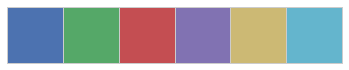

In [11]:
# color palette
current_palette = sns.color_palette()
print(current_palette.as_hex())
sns.palplot(current_palette)

### Benford's Law Distribution

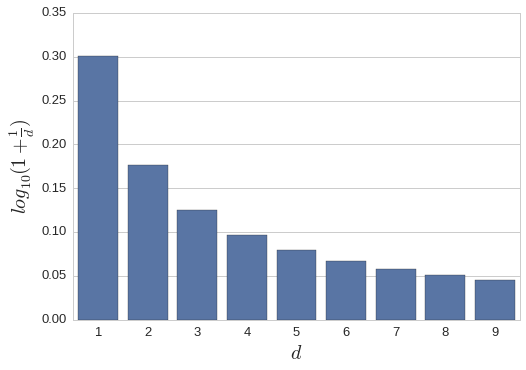

In [12]:
benford_dist = [benford(i) for i in range(1,10)]
digit = np.array(range(1,10))
g = sns.barplot(digit, benford_dist, color='#4c72b0', saturation=0.75)
g.set_xlabel(r'$d$', fontsize=20);
g.set_ylabel(r'$log_{10}(1+\frac{1}{d})$', fontsize=20);

# Datasets

# 1984 A

### Pooling Interviewers

In [15]:
d84 = pd.read_stata('1984A_combined.dta')
d84 = d84[d84.intid.isnull() == False] # Dropping Cases without IntId

In [16]:
firstdigits = d84.filter(regex="fd_")
combined = firstdigits.stack().value_counts().as_matrix()
spread = zip(combined, range(1,10))
fullboot = []
for x,y in spread:
    for i in range(1, int(x)+1):
            fullboot.append(y)
firstdigits['intid'] = d84['intid']
firstdigits.head()
fd_grouped = firstdigits.groupby('intid')
ex_grouped = d84.groupby('intid')['extreme_perc']
var_grouped = d84.groupby('intid')['variance']
fake_grouped = d84.groupby('intid')['fake']
count_grouped = d84.groupby('intid')['n_counter']

d84_combined = pd.DataFrame(index = set(d84.intid))

d84_combined['extreme'] = 0
d84_combined['variance'] = 0

In [ ]:
for id_ in list(set(d84.intid)):
    stacked  = fd_grouped.get_group(id_).stack().value_counts(sort=False).to_dict()
    x_stacked  = ex_grouped.get_group(id_).mean()
    v_stacked = var_grouped.get_group(id_).sum()
    f_stacked = fake_grouped.get_group(id_).mean()
    c_stacked = count_grouped.get_group(id_).mean()
    
    d84_combined.loc[id_,'extreme'] = x_stacked
    d84_combined.loc[id_,'variance'] = v_stacked
    d84_combined.loc[id_,'fake'] = f_stacked
    d84_combined.loc[id_,'n_counter'] = c_stacked
    
    for i in range(1,10):
        if float(i) not in stacked:
            stacked[float(i)] = 0
            d84_combined.loc[id_,[i]] = stacked[i]
        else: 
            d84_combined.loc[id_,i] = stacked[i]
 
d84_combined['sum'] = d84_combined[range(1,10)].sum(axis=1)
d84_combined['var_n'] = d84_combined['variance'] / d84_combined['n_counter']

for i in range(1,10):
    d84_combined[str(i) +'_bf'] = benford(i) * d84_combined['sum']   

#### Plotting digit distributions 

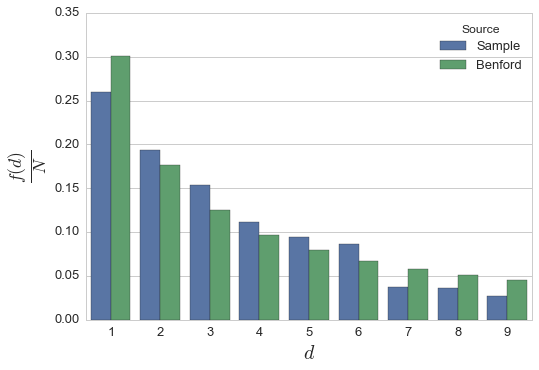

In [232]:
comparison = get_frequencies(fullboot)
g = sns.barplot(x ='digit',y='Relative Frequency', hue='Source',data=comparison)
g.set_xlabel(r'$d$', fontsize=20)
g.set_ylabel(r'$\frac{f(d)}{N}}$', fontsize=25);

### Calculating Chi² Statistics

In [ ]:
d84_combined['chi2'] = d84_combined.apply(chi2_row, axis = 1)
#d84_combined['chi2_p'] = d84_combined.apply(chi2p_row, axis = 1)
d84_combined.dropna(inplace=True)
d84_combined['chi2_boot'] = d84_combined.apply(chi2_bootstrap, axis = 1)

In [ ]:
var_comb = d84_combined['var_n'].tolist()
d84_combined['var_boot'] = d84_combined.apply(var_boot, axis = 1)

### Saving Dataframe with Bootstrap Calculations

In [ ]:
d84_combined.to_pickle('d84chi2_boot')

In [ ]:
d84_combined = pd.read_pickle('d84chi2_boot')

In [ ]:
d84_combined['chi2_sv'] = d84_combined.apply(chi2_bootstrap_sv, axis = 1)

In [27]:
d84_combined.to_pickle('d84chi2_sv')

In [13]:
d84_combined = pd.read_pickle('d84chi2_sv')

### Inspecting Observations

In [28]:
d84_combined.head()

,extreme,variance,fake,1,2,3,4,5,6,7,8,9,sum,1_bf,2_bf,3_bf,4_bf,5_bf,6_bf,7_bf,8_bf,9_bf,chi2,chi2_boot,chi2_sv,n_counter,var_n,var_boot
1003521,0.459669,45495648.421884,0,36,23,20,11,8,6,1,4,2,111,33.414330,19.546130,13.868200,10.757011,8.789118,7.431094,6.437106,5.677930,5.079081,10.828441,0.7485,0.7350,27,1685024.015625,0.0040
1001474,0.535184,48860861.198641,0,54,35,17,9,7,11,0,9,3,145,43.649349,25.533233,18.116117,14.051952,11.481281,9.707284,8.408832,7.417116,6.634836,20.508626,0.2815,0.1030,26,1879263.892255,0.0030
1001476,0.377771,42140409.771932,0,18,17,6,9,4,2,1,2,1,60,18.061800,10.565476,7.496324,5.814601,4.750875,4.016807,3.479517,3.069151,2.745449,10.342999,0.4955,0.3420,15,2809360.651462,0.0065
1003527,0.405559,37498851.533522,0,17,20,9,2,5,6,0,1,2,62,18.663860,10.917658,7.746202,6.008421,4.909237,4.150701,3.595501,3.171456,2.836964,16.735780,0.1225,0.1015,18,2083269.529640,0.0045
1003528,0.387377,33325353.624394,0,43,23,14,11,5,6,5,8,1,116,34.919479,20.426586,14.492893,11.241562,9.185025,7.765828,6.727066,5.933693,5.307869,9.183618,0.8410,0.3890,31,1075011.407239,0.0035


#### Checking Values

In [167]:
d84_combined[['variance', 'var_n', 'extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_boot']].describe()

,variance,var_n,extreme,sum,chi2,chi2_boot,chi2_sv,var_boot
count,6.370000e+02,6.370000e+02,637.000000,637.000000,637.000000,637.000000,637.000000,640.000000
mean,4.744211e+07,6.020804e+06,0.479904,86.419152,14.424353,0.441859,0.414881,0.004669
std,2.800053e+07,1.268482e+07,0.088204,99.797776,10.547191,0.298603,0.299664,0.001559
min,1.107289e+03,2.045520e+02,0.111111,1.000000,1.284215,0.000000,0.000000,0.001000
25%,2.778478e+07,1.370131e+06,0.428015,30.000000,8.270231,0.162500,0.141000,0.003500
50%,4.678319e+07,2.602065e+06,0.474667,61.000000,11.783245,0.416000,0.373500,0.004500
75%,6.425090e+07,5.110492e+06,0.525263,111.000000,16.962986,0.696500,0.665000,0.005500
max,1.849671e+08,1.510900e+08,0.947368,1166.000000,99.222927,1.000000,1.000000,0.010000


In [19]:
d84_results = d84_combined.sort('chi2_boot')[['n_counter', 'sum', \
                                'chi2', 'chi2_boot']]

#### Sorted chi² probability table

In [20]:
d84_results.head(20)

,n_counter,sum,chi2,chi2_boot
1002320,18,53,33.578910,0.0000
1002552,40,99,46.961892,0.0000
1004691,26,117,56.747298,0.0000
128279,35,191,84.319301,0.0000
1001155,29,112,40.717566,0.0005
1003400,78,273,56.446259,0.0010
1001056,23,132,45.136949,0.0010
1001699,41,113,35.322604,0.0020
1003609,11,32,22.484042,0.0025
1002534,13,44,25.639262,0.0030


In [ ]:
print(d84_results.head(20).to_latex())

In [32]:
d84_combined[['variance', 'var_n', 'n_counter', 'extreme', \
                                    'sum', 'chi2', 'chi2_boot', 'chi2_sv']].describe()

,variance,var_n,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv
count,6.370000e+02,6.370000e+02,640.000000,637.000000,637.000000,637.000000,637.000000,637.000000
mean,4.744211e+07,6.020804e+06,19.068750,0.479904,86.419152,14.424353,0.441859,0.414881
std,2.800053e+07,1.268482e+07,20.095507,0.088204,99.797776,10.547191,0.298603,0.299664
min,1.107289e+03,2.045520e+02,1.000000,0.111111,1.000000,1.284215,0.000000,0.000000
25%,2.778478e+07,1.370131e+06,7.000000,0.428015,30.000000,8.270231,0.162500,0.141000
50%,4.678319e+07,2.602065e+06,14.000000,0.474667,61.000000,11.783245,0.416000,0.373500
75%,6.425090e+07,5.110492e+06,24.000000,0.525263,111.000000,16.962986,0.696500,0.665000
max,1.849671e+08,1.510900e+08,222.000000,0.947368,1166.000000,99.222927,1.000000,1.000000


In [33]:
d84_combined[d84_combined.fake==1][['variance', 'var_n', 'n_counter', 'extreme', \
                                    'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_boot']].head()

,variance,var_n,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_boot
128279,35070040.923354,1002001.169239,35,0.310038,191,84.319301,0.0000,0.0000,0.0040
139378,51029964.658371,1594686.395574,32,0.550361,131,26.032175,0.0565,0.1230,0.0035
43800,60871512.082340,1690875.335621,36,0.383957,149,25.034982,0.1415,0.0580,0.0040
165824,63536172.000000,63536172.000000,1,0.947368,6,4.873683,0.7465,0.8125,0.0055


In [34]:
d84_combined[d84_combined.fake==0][['variance', 'var_n', 'n_counter', 'extreme', \
                                    'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_boot']].describe()

,variance,var_n,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_boot
count,6.330000e+02,6.330000e+02,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,4.740934e+07,5.951704e+06,19.110584,0.479474,86.211690,14.293922,0.443159,0.415934,0.004667
std,2.807192e+07,1.251334e+07,20.127453,0.086112,99.928516,10.181586,0.298149,0.299177,0.001564
min,1.107289e+03,2.045520e+02,1.000000,0.111111,1.000000,1.284215,0.000000,0.000000,0.001000
25%,2.777612e+07,1.370131e+06,7.000000,0.428030,30.000000,8.270231,0.163000,0.144500,0.003500
50%,4.677657e+07,2.607269e+06,14.000000,0.474667,61.000000,11.627276,0.418000,0.374000,0.004500
75%,6.500413e+07,5.110492e+06,24.000000,0.525063,111.000000,16.957960,0.696500,0.665000,0.005500
max,1.849671e+08,1.510900e+08,222.000000,0.925000,1166.000000,99.222927,1.000000,1.000000,0.010000


#### Plotting Chi² Benford / Chi² Sample Kernel Density

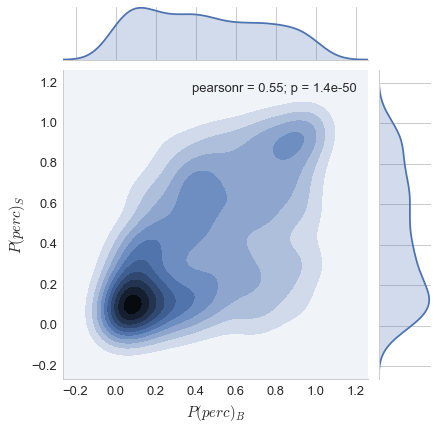

In [244]:
g = sns.jointplot(x="chi2_boot", y="chi2_sv", data=d84_combined, kind="kde")
g.ax_joint.set_xlabel('$P(perc)_{B}$', fontsize=15)
g.ax_joint.set_ylabel('$P(perc)_{S}$', fontsize=15);

# 1998 E

In [263]:
d98 = pd.read_stata('1998E_combined.dta')
d98 = d98[d98.intid.isnull() == False] # Dropping Cases without IntId

### Version 1 - Including Non Monetary

### Pooling Interviewers

In [264]:
firstdigits = d98.filter(regex="fd_")
schraepler = d98.filter(regex="sch_")

combined = schraepler.stack().value_counts().as_matrix()

spread = zip(combined, range(1,10))
fullboot = []
for x,y in spread:
    for i in range(1, int(x)+1):
            fullboot.append(y)

schraepler['intid'] = d98['intid']
firstdigits['intid'] = d98['intid']
firstdigits.head()
fd_grouped = firstdigits.groupby('intid')
schraepler_g = schraepler.groupby('intid')
ex_grouped = d98.groupby('intid')['extreme_perc']
var_grouped = d98.groupby('intid')['variance']
fake_grouped = d98.groupby('intid')['fake']
count_grouped = d98.groupby('intid')['n_counter']

d98_combined = pd.DataFrame(index = set(d98.intid))

d98_combined['extreme'] = 0
d98_combined['variance'] = 0

In [ ]:
d98_schraepler =  pd.DataFrame(index = set(d98.intid))
d98_schraepler['extreme'] = 0
d98_schraepler['variance'] = 0

In [ ]:
for id_ in list(set(d98.intid)):
    stacked  = schraepler_g.get_group(id_).stack().value_counts(sort=False).to_dict()
    x_stacked  = ex_grouped.get_group(id_).mean()
    v_stacked = var_grouped.get_group(id_).sum()
    f_stacked = fake_grouped.get_group(id_).mean()
    c_stacked = count_grouped.get_group(id_).mean()
    
    d98_schraepler.loc[id_,'extreme'] = x_stacked
    d98_schraepler.loc[id_,'variance'] = v_stacked
    d98_schraepler.loc[id_,'fake'] = f_stacked
    d98_schraepler.loc[id_,'n_counter'] = c_stacked
    for i in range(1,10):
        if float(i) not in stacked:
            stacked[float(i)] = 0
            d98_schraepler.loc[id_,[i]] = stacked[i]
        else: 
            d98_schraepler.loc[id_,i] = stacked[i]

In [ ]:
d98_schraepler['var_n'] = d98_schraepler['variance'] / d98_schraepler['n_counter']
d98_schraepler['sum'] = d98_schraepler[range(1,10)].sum(axis=1)

for i in range(1,10):
    d98_schraepler[str(i) +'_bf'] = benford(i) * d98_schraepler['sum']   

#### Plotting digit distributions 

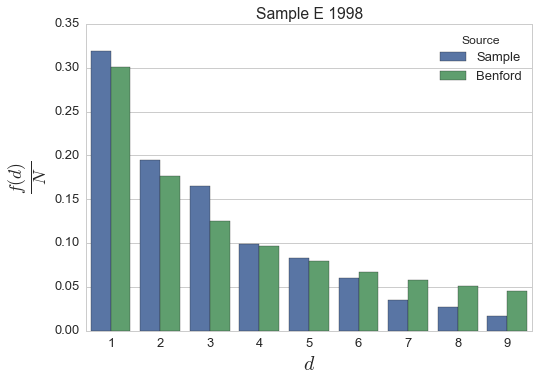

In [265]:
comparison = get_frequencies(fullboot)
g = sns.barplot(x ='digit',y='Relative Frequency', hue='Source',data=comparison)
g.set_title("Sample E 1998")
g.set_xlabel(r'$d$', fontsize=20)
g.set_ylabel(r'$\frac{f(d)}{N}}$', fontsize=25);

### Calculating Chi² Statistics

In [ ]:
var_comb = d98_schraepler['var_n'].tolist()
d98_schraepler['var_boot'] = d98_schraepler.apply(var_boot, axis = 1)

In [ ]:
d98_schraepler['chi2'] = d98_schraepler.apply(chi2_row, axis = 1)
d98_schraepler.dropna(inplace=True)

In [ ]:
d98_schraepler['chi2_boot'] = d98_schraepler.apply(chi2_bootstrap, axis = 1)

In [ ]:
d98_schraepler['chi2_sv'] = d98_schraepler.apply(chi2_bootstrap_sv, axis = 1)


### Saving Dataframe with Bootstrap Calculations

In [ ]:
var_order = pd.DataFrame(d98_schraepler.pop('var_n'))
d98_schraepler = d98_schraepler.join(var_order)

In [ ]:
d98_schraepler.to_pickle('d98schr_chi2_sv') 

In [168]:
d98_schraepler = pd.read_pickle('d98schr_chi2_sv')

In [36]:
d98_schraepler.head()

,extreme,variance,fake,n_counter,1,2,3,4,5,6,7,8,9,sum,1_bf,2_bf,3_bf,4_bf,5_bf,6_bf,7_bf,8_bf,9_bf,chi2,chi2_boot,chi2_sv,var_n,var_boot
1001473,0.468981,349090944,0,13,43,18,18,15,7,3,9,12,2,127,38.230809,22.363590,15.867220,12.307572,10.056018,8.502242,7.364977,6.496370,5.811201,14.336650,0.4395,0.0005,26853150,0.8745
236037,0.465517,21220328,1,1,0,3,2,1,3,0,0,0,0,9,2.709270,1.584821,1.124449,0.872190,0.712631,0.602521,0.521928,0.460373,0.411817,14.011965,0.0515,0.1425,21220328,0.8065
1001990,0.396073,269619840,0,16,33,25,17,18,12,8,6,2,0,121,36.424629,21.307042,15.117587,11.726112,9.580931,8.100562,7.017026,6.189455,5.536656,13.685009,0.4680,0.4080,16851240,0.7155
1003182,0.474291,226834192,0,7,21,18,17,12,2,0,1,0,0,71,21.373130,12.502479,8.870650,6.880611,5.621868,4.753222,4.117428,3.631829,3.248782,30.010343,0.0020,0.0270,32404884,0.9325
1002842,0.571888,164246432,0,12,19,17,18,15,4,6,3,4,0,86,25.888580,15.143848,10.744731,8.334261,6.809587,5.757424,4.987307,4.399117,3.935144,18.223437,0.0830,0.1205,13687203,0.5715


### Inspecting Observations

In [211]:
d98_schraepler.head()

,extreme,variance,fake,n_counter,1,2,3,4,5,6,7,8,9,sum,1_bf,2_bf,3_bf,4_bf,5_bf,6_bf,7_bf,8_bf,9_bf,chi2,chi2_boot,chi2_sv,var_n,var_boot
1001473,0.468981,349090944,0,13,43,18,18,15,7,3,9,12,2,127,38.230809,22.363590,15.867220,12.307572,10.056018,8.502242,7.364977,6.496370,5.811201,14.336650,0.4395,0.0005,26853150,0.8745
236037,0.465517,21220328,1,1,0,3,2,1,3,0,0,0,0,9,2.709270,1.584821,1.124449,0.872190,0.712631,0.602521,0.521928,0.460373,0.411817,14.011965,0.0515,0.1425,21220328,0.8065
1001990,0.396073,269619840,0,16,33,25,17,18,12,8,6,2,0,121,36.424629,21.307042,15.117587,11.726112,9.580931,8.100562,7.017026,6.189455,5.536656,13.685009,0.4680,0.4080,16851240,0.7155
1003182,0.474291,226834192,0,7,21,18,17,12,2,0,1,0,0,71,21.373130,12.502479,8.870650,6.880611,5.621868,4.753222,4.117428,3.631829,3.248782,30.010343,0.0020,0.0270,32404884,0.9325
1002842,0.571888,164246432,0,12,19,17,18,15,4,6,3,4,0,86,25.888580,15.143848,10.744731,8.334261,6.809587,5.757424,4.987307,4.399117,3.935144,18.223437,0.0830,0.1205,13687203,0.5715


#### Sorted chi² probability table

In [204]:
d98_results = d98_schraepler.sort('chi2_boot')[['n_counter', 'sum', \
                                'chi2', 'chi2_boot']]

In [205]:
d98_results.head(20)

,n_counter,sum,chi2,chi2_boot
1004192,10,64,35.796047,0.0000
1003239,12,40,40.062561,0.0000
1004393,15,61,42.582042,0.0000
1002972,21,144,40.759380,0.0005
249289,20,121,39.243785,0.0005
1003478,49,177,43.410499,0.0005
1003986,3,27,32.205972,0.0005
249281,2,7,28.150848,0.0015
1003367,13,109,31.558987,0.0015
1003182,7,71,30.010343,0.0020


In [ ]:
print(d98_results.head(20).to_latex())

In [169]:
d98_schraepler[['variance', 'var_n', 'extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv']].describe()

,variance,var_n,extreme,sum,chi2,chi2_boot,chi2_sv
count,137,137,137.000000,137.000000,137.000000,137.000000,137.000000
mean,196438976,16065648,0.428836,87.021898,17.506717,0.260091,0.212770
std,183009776,12597455,0.068142,61.474704,8.582220,0.264289,0.226424
min,3123154,1701083,0.218954,4.000000,2.475318,0.000000,0.000000
25%,71634216,8743812,0.381639,37.000000,11.211047,0.043000,0.023500
50%,164246432,13018634,0.433723,83.000000,15.469453,0.186000,0.123000
75%,240365888,19042852,0.473390,119.000000,21.126031,0.417000,0.350000
max,1020251072,103107672,0.584906,403.000000,43.410499,0.998000,0.934500


In [170]:
d98_schraepler[d98_schraepler.fake==1][['variance','var_n', 'extreme', 'sum', 'n_counter', \
                                        'chi2', 'chi2_boot', 'chi2_sv', 'var_boot']].head()

,variance,var_n,extreme,sum,n_counter,chi2,chi2_boot,chi2_sv,var_boot
236037,21220328,21220328.0,0.465517,9,1,14.011965,0.0515,0.1425,0.8065
236807,16763798,16763798.0,0.446154,10,1,8.370533,0.3150,0.4395,0.6845
236837,311206112,13530701.0,0.465744,166,23,34.382874,0.0040,0.0140,0.5615
249281,6243401,3121700.5,0.332075,7,2,28.150848,0.0015,0.0020,0.0235
249289,187305920,9365296.0,0.298916,121,20,39.243785,0.0005,0.0000,0.3255


#### Plotting Chi² Benford / Chi² Sample Kernel Density

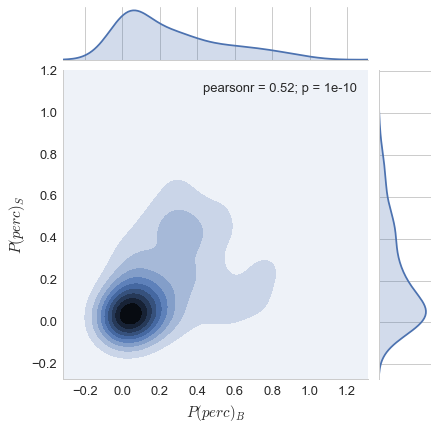

In [245]:
g = sns.jointplot(x="chi2_boot", y="chi2_sv", data=d98_schraepler, kind="kde")
g.ax_joint.set_xlabel('$P(perc)_{B}$', fontsize=15)
g.ax_joint.set_ylabel('$P(perc)_{S}$', fontsize=15);

#### Variable Differences

Here the differences between the two variants of variable selection are listed.

In [161]:
# only monetary variables
raw1 = "op1801 op4501 op4502 op4801 op4802 op4902 op4904 \
op4906 op4908 op4910 op4912 op4914 op4916 op4918 op4920 \
op4922 op5602 op58a03 op58b03 op58c03 op58d03 op58e03 \
op58f03 op58g03 op58h03 op58i03 op58j03 op58k03 op58l03 \
op58m03 op5902 op5904 op5906 op5908 op5910 op5912 op6101 \
op6102 op6103 op6104 op6105 op6106 op6107 op6108 op6109 \
op6110 op6111 op6112 op6113 op6114 op6115 op6116 op6117 \
op6118 op6309 op6312 op12206 op12210 op12218"
shortlist1 = raw1.split(" ")

In [162]:
# including non-monetary variables
raw2 =  "op1801 op2202 op4401 op4501 op4502 op4801 op4802 op4902 op4904 op4906 op4908 \
op4910 op4912 op4914 op4916 op4918 op4920 op4922 op5602 op58a03 op58b03 op58c03 op58d03 \
op58e03 op58f03 op58g03 op58h03 op58i03 op58j03 op58k03 op58l03 op58m03 op5902 op5904 op5906 \
op5908 op5910 op5912 op6101 op6102 op6103 op6104 op6105 op6106 op6107 op6108 op6109 \
op6110 op6111 op6112 op6113 op6114 op6115 op6116 op6117 op6118 op6309 op6312 op7002 \
op7101 op7202 op7203 op9001 op9101 op9102 op9301 op9302 op9303 op9304 op12202 op12206 op12210 op12218"
shortlist2 = raw2.split(" ")

In [163]:
print([val for val in shortlist2 if val not in shortlist1])

['op2202', 'op4401', 'op7002', 'op7101', 'op7202', 'op7203', 'op9001', 'op9101', 'op9102', 'op9301', 'op9302', 'op9303', 'op9304', 'op12202']


This is the list of variables that are additionally included in version 1.

<table width="100%" cellpadding="4" cellspacing="0">
    <colgroup>
        <col width="128*"/>
        <col width="128*"/>
    </colgroup>
    <tbody>
        <tr valign="top">
            <td width="50%">
                <p>
                    variable
                </p>
            </td>
            <td width="50%">
                <p>
                    variable label
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
            </td>
            <td width="50%">
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op2202
                </p>
            </td>
            <td width="50%">
                <p>
                    Jetzige Stelle angetreten Monat 98
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op4401
                </p>
            </td>
            <td width="50%">
                <p>
                    Ueberstunden letzten Monat-Anzahl
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op7002
                </p>
            </td>
            <td width="50%">
                <p>
                    Behinderungsgrad
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op7101
                </p>
            </td>
            <td width="50%">
                <p>
                    Arztbesuche Anzahl
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op7202
                </p>
            </td>
            <td width="50%">
                <p>
                    Krankenhausaufenth. 97 Anzahl
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op7203
                </p>
            </td>
            <td width="50%">
                <p>
                    Krankenhausaufenth. 97 Naechte
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9001
                </p>
            </td>
            <td width="50%">
                <p>
                    Entfernung Arbeit in km
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9101
                </p>
            </td>
            <td width="50%">
                <p>
                    Fahrtzeit Whg-Arbeit-Std
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9102
                </p>
            </td>
            <td width="50%">
                <p>
                    Fahrtzeit Whg-Arbeit-Min
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9301
                </p>
            </td>
            <td width="50%">
                <p>
                    Fahrtzeit Auto-Std
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9302
                </p>
            </td>
            <td width="50%">
                <p>
                    Fahrtzeit Auto-Min
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9303
                </p>
            </td>
            <td width="50%">
                <p>
                    Fahrtzeit OePNV-Std
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op9304
                </p>
            </td>
            <td width="50%">
                <p>
                    Fahrtzeit OePNV-Min
                </p>
            </td>
        </tr>
        <tr valign="top">
            <td width="50%">
                <p>
                    op12202
                </p>
            </td>
            <td width="50%">
                <p>
                    An Eltern, Schwiegereltern Betrag
                </p>
            </td>
        </tr>
    </tbody>
</table>

### Version 2 - Only Monetary (not included in the paper)

### Pooling Interviewers

In [266]:
firstdigits = d98.filter(regex="fd_")
combined = firstdigits.stack().value_counts().as_matrix()
spread = zip(combined, range(1,10))
fullboot = []
for x,y in spread:
    for i in range(1, int(x)+1):
            fullboot.append(y)

In [ ]:
for id_ in list(set(d98.intid)):
    stacked  = fd_grouped.get_group(id_).stack().value_counts(sort=False).to_dict()
    x_stacked  = ex_grouped.get_group(id_).mean()
    v_stacked = var_grouped.get_group(id_).mean()
    f_stacked = fake_grouped.get_group(id_).mean()
    c_stacked = count_grouped.get_group(id_).mean()
    
    d98_combined.loc[id_,'extreme'] = x_stacked
    d98_combined.loc[id_,'variance'] = v_stacked
    d98_combined.loc[id_,'fake'] = f_stacked
    d98_combined.loc[id_,'n_counter'] = c_stacked
    
    for i in range(1,10):
        if float(i) not in stacked:
            stacked[float(i)] = 0
            d98_combined.loc[id_,[i]] = stacked[i]
        else: 
            d98_combined.loc[id_,i] = stacked[i]
 
d98_combined['sum'] = d98_combined[range(1,10)].sum(axis=1)
d98_combined['var_n'] = d98_scombined['variance'] / d98_combined['n_counter']

for i in range(1,10):
    d98_combined[str(i) +'_bf'] = benford(i) * d98_combined['sum']   

#### Plotting digit distributions 

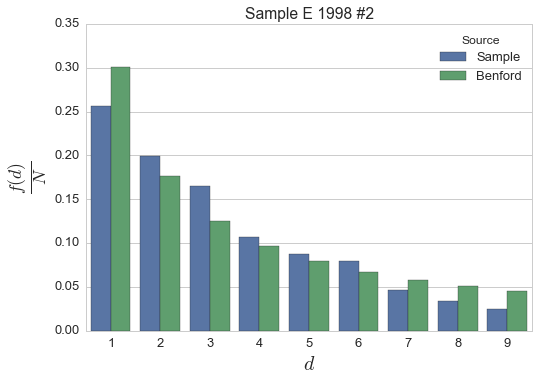

In [267]:
comparison = get_frequencies(fullboot)
g = sns.barplot(x ='digit',y='Relative Frequency', hue='Source',data=comparison)
g.set_title("Sample E 1998 #2")
g.set_xlabel(r'$d$', fontsize=20)
g.set_ylabel(r'$\frac{f(d)}{N}}$', fontsize=25);

### Calculating Chi²-Statistics

In [ ]:
d98_combined['chi2'] = d98_combined.apply(chi2_row, axis = 1)
d98_combined.dropna(inplace=True)

In [ ]:
d98_combined['chi2_boot'] = d98_combined.apply(chi2_bootstrap, axis = 1)

In [ ]:
d98_combined['chi2_sv'] = d98_combined.apply(chi2_bootstrap_sv, axis = 1)

In [ ]:
d98_combined[d98_combined.fake==1][['extreme', 'sum', 'chi2', 'chi2_boot']].head()

In [ ]:
d98_combined['chi2_sv'] = d98_combined.apply(chi2_bootstrap_sv, axis = 1)

#### Saving Dataframe with Bootstrap Replications

In [ ]:
d98_combined.to_pickle('d98chi2_boot')

In [21]:
d98_combined= pd.read_pickle('d98chi2_boot')

### Inspecting Observations

In [22]:
d98_combined.sort('chi2_boot')[['extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'fake']].head(30)

,extreme,sum,chi2,chi2_boot,chi2_sv,fake
1004192,0.522443,32,35.210954,0.0000,0.0020,0
1001895,0.438425,24,28.631810,0.0000,0.0115,0
1004393,0.408644,43,44.450628,0.0000,0.0000,0
1004310,0.405386,30,29.968042,0.0000,0.0045,0
1003926,0.377737,52,36.614756,0.0000,0.0000,0
1002355,0.349937,34,32.025036,0.0000,0.0000,0
1003986,0.473390,13,52.141948,0.0000,0.0010,0
1002479,0.426139,16,38.686524,0.0000,0.0015,0
1003239,0.305102,31,44.582803,0.0000,0.0000,0
1003478,0.377540,91,78.279524,0.0000,0.0000,0


In [164]:
d98_combined[d98_combined.fake==1][['extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv']].head()

,extreme,sum,chi2,chi2_boot,chi2_sv
236037,0.465517,6,9.259213,0.1785,0.4305
236807,0.446154,5,8.969006,0.1630,0.3180
236837,0.465744,93,19.059969,0.1480,0.0320
249281,0.332075,6,28.383971,0.0015,0.0020
249289,0.298916,63,20.953164,0.0325,0.0025


In [165]:
d98_combined[d98_combined.fake==0][['chi2', 'chi2_boot', 'chi2_sv', 'extreme', 'var_n']].describe()

,chi2,chi2_boot,chi2_sv,extreme,var_n
count,132.000000,132.000000,132.000000,132.000000,132.000000
mean,19.252056,0.178235,0.164659,0.429865,2934920.385097
std,10.620316,0.259823,0.240908,0.067795,6407995.413521
min,2.890584,0.000000,0.000000,0.218954,106905.343483
25%,11.765940,0.004750,0.008375,0.384510,602914.486828
50%,17.956490,0.045500,0.046250,0.432445,1143702.266493
75%,24.148678,0.250500,0.214625,0.476162,2232819.759835
max,78.279524,0.987500,0.963500,0.584906,51553836.000000


In [ ]:
d98_final = d98_schraepler[[ 'chi2_sv', 'chi2_boot']]
X =d98_final.dropna().values

# 1999 E

In [256]:
d99 = pd.read_stata('1999E_combined.dta')
d99 = d99[d99.intid.isnull() == False] # Dropping Cases without IntId

### Pooling Interviews

In [257]:
firstdigits = d99.filter(regex="fd_")
combined = firstdigits.stack().value_counts().as_matrix()

spread = zip(combined, range(1,10))
fullboot = []
for x,y in spread:
    for i in range(1, int(x)+1):
            fullboot.append(y)

firstdigits['intid'] = d99['intid']
fd_grouped = firstdigits.groupby('intid')
ex_grouped = d99.groupby('intid')['extreme_perc']
var_grouped = d99.groupby('intid')['variance']
fake_grouped = d99.groupby('intid')['fake']
count_grouped = d99.groupby('intid')['n_counter']


d99_combined = pd.DataFrame(index = set(d99.intid))
d99_combined['extreme'] = 0
d99_combined['variance'] = 0

In [ ]:
for id_ in list(set(d99.intid)):
    stacked  = fd_grouped.get_group(id_).stack().value_counts(sort=False).to_dict()
    x_stacked  = ex_grouped.get_group(id_).mean()
    v_stacked = var_grouped.get_group(id_).mean()
    f_stacked = fake_grouped.get_group(id_).mean()
    c_stacked = count_grouped.get_group(id_).mean()
    
    d99_combined.loc[id_,'extreme'] = x_stacked
    d99_combined.loc[id_,'variance'] = v_stacked
    d99_combined.loc[id_,'fake'] = f_stacked
    d99_combined.loc[id_,'n_counter'] = c_stacked
    
    for i in range(1,10):
        if float(i) not in stacked:
            stacked[float(i)] = 0
            d99_combined.loc[id_,[i]] = stacked[i]
        else: 
            d99_combined.loc[id_,i] = stacked[i]
 
d99_combined['sum'] = d99_combined[range(1,10)].sum(axis=1)
d99_combined['var_n'] = d99_combined['variance'] / d99_combined['n_counter']

for i in range(1,10):
    d99_combined[str(i) +'_bf'] = benford(i) * d99_combined['sum']   

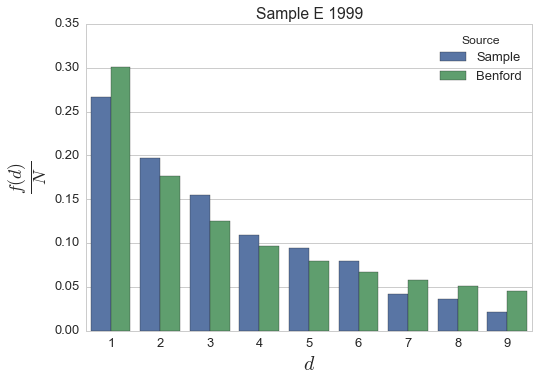

In [259]:
comparison = get_frequencies(fullboot)
g = sns.barplot(x ='digit',y='Relative Frequency', hue='Source',data=comparison)
g.set_title("Sample E 1999")
g.set_xlabel(r'$d$', fontsize=20)
g.set_ylabel(r'$\frac{f(d)}{N}}$', fontsize=25);

### Calculating Chi²-Statistics

In [ ]:
d99_combined['chi2'] = d99_combined.apply(chi2_row, axis = 1)
#d84_combined['chi2_p'] = d84_combined.apply(chi2p_row, axis = 1)
d99_combined.dropna(inplace=True)
d99_combined['chi2_boot'] = d99_combined.apply(chi2_bootstrap, axis = 1)

In [ ]:
d99_combined['chi2_sv'] = d99_combined.apply(chi2_bootstrap_sv, axis = 1)

### Saving DataFrame with Bootstrap Replications

In [ ]:
var_order = pd.DataFrame(d99_combined.pop('var_n'))
d99_combined = d99_combined.join(var_order)

In [ ]:
d99_combined.to_pickle('d99_chi2_sv') 

In [172]:
d99_combined = pd.read_pickle('d99_chi2_sv')

### Inspecting Observations

In [46]:
d99_combined.head()

,extreme,variance,fake,n_counter,1,2,3,4,5,6,7,8,9,sum,1_bf,2_bf,3_bf,4_bf,5_bf,6_bf,7_bf,8_bf,9_bf,chi2,chi2_boot,chi2_sv,var_n
1001473,0.390870,23832414,0,13,13,13,6,9,7,4,5,8,2,67,20.16901,11.798114,8.370895,6.492971,5.305143,4.485435,3.885460,3.427219,3.065752,11.695593,0.0160,0.0000,1833262.625
1001475,0.394737,15053541,0,2,2,2,0,2,0,3,0,0,0,9,2.70927,1.584821,1.124449,0.872190,0.712631,0.602521,0.521928,0.460373,0.411817,14.523748,0.0605,0.0315,7526770.500
1001990,0.340380,36285952,0,12,7,6,13,7,4,4,10,2,3,56,16.85768,9.861111,6.996569,5.426961,4.434150,3.749020,3.247549,2.864541,2.562419,27.318364,0.0000,0.0000,3023829.250
1004055,0.287879,13686236,0,1,0,0,0,0,0,1,0,0,3,4,1.20412,0.704365,0.499755,0.387640,0.316725,0.267787,0.231968,0.204610,0.183030,48.906586,0.2785,0.2140,13686236.000
1001306,0.275862,17155986,0,1,1,2,0,3,0,0,0,0,0,6,1.80618,1.056548,0.749632,0.581460,0.475087,0.401681,0.347952,0.306915,0.274545,13.817847,0.0675,0.1670,17155986.000


In [196]:
d99_combined.sort('chi2_boot')[['extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n', 'fake']].head(20)

,extreme,sum,chi2,chi2_boot,chi2_sv,var_n,fake
1001990,0.340380,56,27.318364,0.0000,0.0000,3023829.250000,0
1001112,0.408844,59,39.006911,0.0000,0.0000,1818517.625000,0
1002077,0.430652,53,42.947528,0.0000,0.0010,734746.687500,0
1003554,0.335859,124,41.839288,0.0000,0.0005,1398398.500000,0
1003986,0.505305,17,31.539877,0.0000,0.0030,4887945.500000,0
1004071,0.410887,67,28.789602,0.0000,0.0070,2824501.000000,0
1003478,0.391779,116,50.954112,0.0000,0.0005,111931.289062,0
1002355,0.499323,50,30.065800,0.0005,0.0005,1208122.750000,0
1001171,0.317459,38,26.901860,0.0005,0.0065,4689393.000000,0
1003696,0.342891,44,31.210149,0.0005,0.0150,2245444.750000,0


In [49]:
d99_combined[['variance', 'var_n', 'extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv']].describe()

,variance,var_n,extreme,sum,chi2,chi2_boot,chi2_sv
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,18426590.000000,2741963.000000,0.404310,45.456000,18.371801,0.342368,0.173712
std,14873155.000000,3749649.000000,0.082418,34.075936,10.725211,0.358985,0.272428
min,19007.935547,9503.967773,0.218150,1.000000,2.321928,0.000000,0.000000
25%,8388889.000000,734746.687500,0.351852,19.000000,10.703308,0.013500,0.003500
50%,14663837.000000,1605494.500000,0.400643,42.000000,15.768108,0.198500,0.028500
75%,23107264.000000,3023829.250000,0.446154,62.000000,23.546460,0.636500,0.214000
max,76784128.000000,24238216.000000,0.699567,212.000000,61.859634,1.000000,1.000000


In [48]:
d99_combined[d99_combined.fake==1][['variance','var_n', 'extreme', 'sum', 'n_counter', \
                                        'chi2', 'chi2_boot', 'chi2_sv']]

,variance,var_n,extreme,sum,n_counter,chi2,chi2_boot,chi2_sv
249289,8197260.5,372602.75,0.21815,71,22,61.859634,0.0005,0


#### Plotting Chi² Benford / Chi² Sample Kernel Density

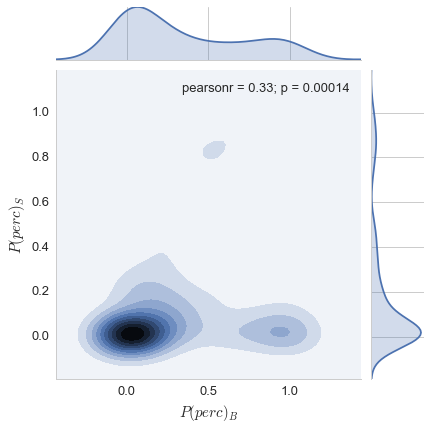

In [246]:
g = sns.jointplot(x="chi2_boot", y="chi2_sv", data=d99_combined, kind="kde")
g.ax_joint.set_xlabel('$P(perc)_{B}$', fontsize=15)
g.ax_joint.set_ylabel('$P(perc)_{S}$', fontsize=15);

# 2000 F

In [137]:
d2k = pd.read_stata('2000F_combined.dta')
d2k = d2k[d2k.intid.isnull() == False] # Dropping Cases without IntId

### Pooling Interviews

In [138]:
firstdigits = d2k.filter(regex="fd_")
combined = firstdigits.stack().value_counts().as_matrix()
spread = zip(combined, range(1,10))
fullboot = []
for x,y in spread:
    for i in range(1, int(x)+1):
            fullboot.append(y)
firstdigits['intid'] = d2k['intid']

fd_grouped = firstdigits.groupby('intid')
ex_grouped = d2k.groupby('intid')['extreme_perc']
var_grouped = d2k.groupby('intid')['variance']
fake_grouped = d2k.groupby('intid')['fake']
count_grouped = d2k.groupby('intid')['n_counter']

d2k_combined = pd.DataFrame(index = set(d2k.intid))

d2k_combined['extreme'] = 0
d2k_combined['variance'] = 0

In [ ]:
for id_ in list(set(d2k.intid)):
    stacked  = fd_grouped.get_group(id_).stack().value_counts(sort=False).to_dict()
    x_stacked  = ex_grouped.get_group(id_).mean()
    v_stacked = var_grouped.get_group(id_).sum()
    f_stacked = fake_grouped.get_group(id_).mean()
    c_stacked = count_grouped.get_group(id_).mean()
    
    
    d2k_combined.loc[id_,'extreme'] = x_stacked
    d2k_combined.loc[id_,'variance'] = v_stacked
    d2k_combined.loc[id_,'fake'] = f_stacked
    d2k_combined.loc[id_,'n_counter'] = c_stacked
    
    for i in range(1,10):
        if float(i) not in stacked:
            stacked[i] = 0
            d2k_combined.loc[id_,i] = stacked[i]
        else: 
            d2k_combined.loc[id_,i] = stacked[i]
 
d2k_combined['sum'] = d2k_combined[range(1,10)].sum(axis=1)
d2k_combined['var_n'] = d2k_combined['variance'] / d2k_combined['n_counter']

for i in range(1,10):
    d2k_combined[str(i) +'_bf'] = benford(i) * d2k_combined['sum']   

#### Plotting digit distributions 

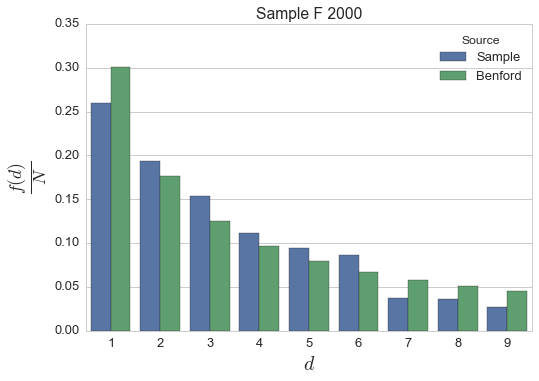

In [139]:
comparison = get_frequencies(fullboot)
g = sns.barplot(x ='digit',y='Relative Frequency', hue='Source',data=comparison)
g.set_title("Sample F 2000")
g.set_xlabel(r'$d$', fontsize=20)
g.set_ylabel(r'$\frac{f(d)}{N}}$', fontsize=25);

### Calculating Chi²-Statistics

In [ ]:
d2k_combined['chi2'] = d2k_combined.apply(chi2_row, axis = 1)
d2k_combined.dropna(inplace=True)
d2k_combined['chi2_boot'] = d2k_combined.apply(chi2_bootstrap, axis = 1)

In [ ]:
d2k_combined['chi2_sv'] = d2k_combined.apply(chi2_bootstrap_sv, axis = 1)

### Saving DataFrame with Bootstrap Replications

In [ ]:
var_order = pd.DataFrame(d2k_combined.pop('var_n'))
d2k_combined = d2k_combined.join(var_order)

In [ ]:
d2k_combined.to_pickle('d2kchi2_sv')

In [50]:
d2k_combined = pd.read_pickle('d2kchi2_sv')

### Inspecting Observations

In [51]:
d2k_combined.head()

,extreme,variance,fake,n_counter,1,2,3,4,5,6,7,8,9,sum,1_bf,2_bf,3_bf,4_bf,5_bf,6_bf,7_bf,8_bf,9_bf,chi2,chi2_boot,chi2_sv,var_n
1001480,0.356078,178538704,0,10,18,6,6,1,11,4,0,0,0,46,13.847380,8.100198,5.747182,4.457861,3.642337,3.079552,2.667630,2.353016,2.104845,26.746514,0.0055,0.0100,17853870
1004204,0.107143,27405996,0,2,0,0,1,3,0,1,0,0,0,5,1.505150,0.880456,0.624694,0.484550,0.395906,0.334734,0.289960,0.255763,0.228787,18.162164,0.0250,0.0695,13702998
1001483,0.353124,2009627392,0,43,27,28,19,8,9,16,4,3,4,118,35.521539,20.778769,14.742771,11.435382,9.343387,7.899721,6.843050,6.035998,5.399384,18.204757,0.1560,0.4320,46735520
1003533,0.227893,29753220,0,3,0,2,0,0,0,7,0,0,0,9,2.709270,1.584821,1.124449,0.872190,0.712631,0.602521,0.521928,0.460373,0.411817,74.848896,0.0000,0.0000,9917740
1001491,0.442018,401877056,0,16,16,22,8,2,2,1,1,2,2,56,16.857680,9.861111,6.996569,5.426961,4.434150,3.749020,3.247549,2.864541,2.562419,22.586210,0.0190,0.0115,25117316


In [52]:
d2k_combined[d2k_combined.fake==1].head()

,extreme,variance,fake,n_counter,1,2,3,4,5,6,7,8,9,sum,1_bf,2_bf,3_bf,4_bf,5_bf,6_bf,7_bf,8_bf,9_bf,chi2,chi2_boot,chi2_sv,var_n
270857,0.108766,95423160,1,11,13,8,0,0,0,0,6,11,5,43,12.94429,7.571924,5.372366,4.167131,3.404794,2.878712,2.493654,2.199558,1.967572,60.66193,0,0,8674833


In [53]:
d2k_combined.sort('chi2_boot')[['extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n', 'n_counter']].head(30)

,extreme,sum,chi2,chi2_boot,chi2_sv,var_n,n_counter
1001858,0.370822,38,63.893658,0,0.0000,43184520.00,9
1002813,0.281722,59,44.036153,0,0.0000,56452996.00,15
1001583,0.353687,100,49.620452,0,0.0000,45117368.00,22
1002477,0.350431,45,35.335733,0,0.0065,80257840.00,13
1004293,0.264813,56,51.497184,0,0.0000,38426440.00,11
1002751,0.254981,130,74.326137,0,0.0000,36437312.00,32
1004307,0.256494,3,55.648134,0,0.0000,2307787.75,2
1003215,0.412558,40,37.497720,0,0.0020,22595578.00,14
1003261,0.302356,63,55.102984,0,0.0000,43021504.00,21
1002421,0.261996,144,56.926720,0,0.0000,17809122.00,52


In [54]:
d2k_combined[['extreme', 'sum', 'chi2', 'chi2_boot',  'variance', 'n_counter', 'var_n']].describe()

,extreme,sum,chi2,chi2_boot,variance,n_counter,var_n
count,534.000000,534.000000,534.000000,534.000000,5.340000e+02,534.000000,5.340000e+02
mean,0.365059,65.202247,20.220356,0.192340,6.153602e+08,20.312735,3.337204e+07
std,0.079853,65.500185,12.149159,0.237176,6.597337e+08,19.540346,3.456490e+07
min,0.107143,1.000000,2.321928,0.000000,1.722175e+06,1.000000,1.012939e+06
25%,0.318688,25.000000,12.000817,0.014125,1.926874e+08,8.000000,1.751176e+07
50%,0.360103,48.500000,17.607893,0.081500,4.089639e+08,15.000000,2.583396e+07
75%,0.403231,83.750000,25.016479,0.288375,8.393123e+08,25.750000,4.026607e+07
max,0.744565,644.000000,77.538022,1.000000,6.564135e+09,175.000000,3.999249e+08


In [55]:
d2k_combined[d2k_combined.fake==1][['extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n']].head()

,extreme,sum,chi2,chi2_boot,chi2_sv,var_n
270857,0.108766,43,60.66193,0,0,8674833


#### Plotting Chi² Benford / Chi² Sample Kernel Density

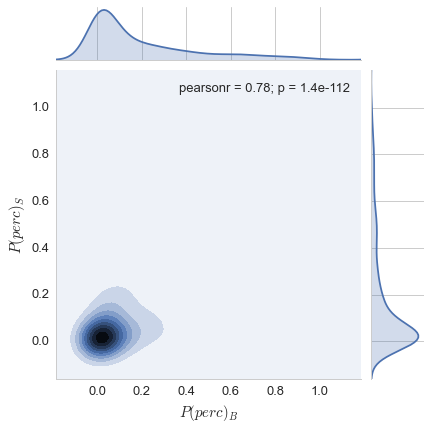

In [247]:
g = sns.jointplot(x="chi2_boot", y="chi2_sv", data=d2k_combined, kind="kde")
g.ax_joint.set_xlabel('$P(perc)_{B}$', fontsize=15)
g.ax_joint.set_ylabel('$P(perc)_{S}$', fontsize=15);

## Classification

In [23]:
d84_combined = pd.read_pickle('d84chi2_sv')
d98_schraepler = pd.read_pickle('d98schr_chi2_sv')
d98_combined= pd.read_pickle('d98chi2_boot')
d99_combined = pd.read_pickle('d99_chi2_sv')
d2k_combined = pd.read_pickle('d2kchi2_sv')

#### Inspecting Datasets

##### 1984

In [625]:
# Fakes
d84_combined[d84_combined.fake==1][['n_counter','extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n']].head()

,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_n
128279,35,0.310038,191,84.319301,0.0000,0.0000,1002001.169239
139378,32,0.550361,131,26.032175,0.0565,0.1230,1594686.395574
43800,36,0.383957,149,25.034982,0.1415,0.0580,1690875.335621
165824,1,0.947368,6,4.873683,0.7465,0.8125,63536172.000000


In [56]:
d84_combined[['chi2', 'chi2_boot', 'chi2_sv', 'extreme', 'var_n']].describe()

,chi2,chi2_boot,chi2_sv,extreme,var_n
count,637.000000,637.000000,637.000000,637.000000,6.370000e+02
mean,14.424353,0.441859,0.414881,0.479904,6.020804e+06
std,10.547191,0.298603,0.299664,0.088204,1.268482e+07
min,1.284215,0.000000,0.000000,0.111111,2.045520e+02
25%,8.270231,0.162500,0.141000,0.428015,1.370131e+06
50%,11.783245,0.416000,0.373500,0.474667,2.602065e+06
75%,16.962986,0.696500,0.665000,0.525263,5.110492e+06
max,99.222927,1.000000,1.000000,0.947368,1.510900e+08


##### 1998

In [624]:
#Fakes
d98_schraepler[d98_schraepler.fake==1][['n_counter','extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n']].head()

,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_n
236037,1,0.465517,9,14.011965,0.0515,0.1425,21220328.0
236807,1,0.446154,10,8.370533,0.3150,0.4395,16763798.0
236837,23,0.465744,166,34.382874,0.0040,0.0140,13530701.0
249281,2,0.332075,7,28.150848,0.0015,0.0020,3121700.5
249289,20,0.298916,121,39.243785,0.0005,0.0000,9365296.0


In [57]:
d98_schraepler[['chi2', 'chi2_boot', 'chi2_sv', 'extreme', 'var_n']].describe()

,chi2,chi2_boot,chi2_sv,extreme,var_n
count,137.000000,137.000000,137.000000,137.000000,137
mean,17.506717,0.260091,0.212770,0.428836,16065648
std,8.582220,0.264289,0.226424,0.068142,12597455
min,2.475318,0.000000,0.000000,0.218954,1701083
25%,11.211047,0.043000,0.023500,0.381639,8743812
50%,15.469453,0.186000,0.123000,0.433723,13018634
75%,21.126031,0.417000,0.350000,0.473390,19042852
max,43.410499,0.998000,0.934500,0.584906,103107672


In [58]:
#Fakes
d98_combined[d98_combined.fake==1][['n_counter','extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n']].head()

,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_n
236037,1,0.465517,6,9.259213,0.1785,0.4305,21220328.000000
236807,1,0.446154,5,8.969006,0.1630,0.3180,16763798.000000
236837,23,0.465744,93,19.059969,0.1480,0.0320,588291.303391
249281,2,0.332075,6,28.383971,0.0015,0.0020,1560850.312500
249289,20,0.298916,63,20.953164,0.0325,0.0025,468264.819561


In [59]:
d98_combined[['chi2', 'chi2_boot', 'chi2_sv', 'extreme', 'var_n']].describe()

,chi2,chi2_boot,chi2_sv,extreme,var_n
count,137.000000,137.000000,137.000000,137.000000,137.000000
mean,19.181728,0.175551,0.164380,0.428836,3124168.053053
std,10.525487,0.255760,0.238983,0.068142,6593970.946489
min,2.890584,0.000000,0.000000,0.218954,106905.343483
25%,11.357178,0.005000,0.008000,0.381639,588291.303391
50%,17.989158,0.048500,0.044500,0.433723,1146804.221110
75%,24.122741,0.230000,0.218000,0.473390,2274765.484375
max,78.279524,0.987500,0.963500,0.584906,51553836.000000


#### 1999

In [623]:
#Fakes
d99_combined[d99_combined.fake==1][['n_counter','extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n']].head()

,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_n
249289,22,0.21815,71,61.859634,0.0005,0,372602.75


In [60]:
d99_combined[['chi2', 'chi2_boot', 'chi2_sv', 'extreme', 'var_n']].describe()

,chi2,chi2_boot,chi2_sv,extreme,var_n
count,125.000000,125.000000,125.000000,125.000000,125.000000
mean,18.371801,0.342368,0.173712,0.404310,2741963.000000
std,10.725211,0.358985,0.272428,0.082418,3749649.000000
min,2.321928,0.000000,0.000000,0.218150,9503.967773
25%,10.703308,0.013500,0.003500,0.351852,734746.687500
50%,15.768108,0.198500,0.028500,0.400643,1605494.500000
75%,23.546460,0.636500,0.214000,0.446154,3023829.250000
max,61.859634,1.000000,1.000000,0.699567,24238216.000000


#### 2000

In [62]:
# Fakes
d2k_combined[d2k_combined.fake==1][['n_counter','extreme', 'sum', 'chi2', 'chi2_boot', 'chi2_sv', 'var_n']].head()

,n_counter,extreme,sum,chi2,chi2_boot,chi2_sv,var_n
270857,11,0.108766,43,60.66193,0,0,8674833


In [63]:
d2k_combined[['chi2', 'chi2_boot', 'chi2_sv', 'extreme', 'var_n']].describe()

,chi2,chi2_boot,chi2_sv,extreme,var_n
count,534.000000,534.000000,534.000000,534.000000,5.340000e+02
mean,20.220356,0.192340,0.171195,0.365059,3.337204e+07
std,12.149159,0.237176,0.234942,0.079853,3.456490e+07
min,2.321928,0.000000,0.000000,0.107143,1.012939e+06
25%,12.000817,0.014125,0.007000,0.318688,1.751176e+07
50%,17.607893,0.081500,0.057000,0.360103,2.583396e+07
75%,25.016479,0.288375,0.245375,0.403231,4.026607e+07
max,77.538022,1.000000,1.000000,0.744565,3.999249e+08


## Training on 84 and 98

### Preparations

Dropping five interviewer who conducted only one interview for improving training data quality, as the Chi² calcuations are not helpful for very few observed digits. This includes two fakers from sample E 1998.

In [24]:
d84_train = d84_combined[d84_combined.n_counter != 1]

In [25]:
d98_train = d98_schraepler[d98_schraepler.n_counter != 1]

In [26]:
features98 = d98_train[['extreme', 'chi2_boot',  'chi2_sv']].values
features84 = d84_train[['extreme', 'chi2_boot',  'chi2_sv']].values
labels98 = d98_train['fake'].values
labels84 = d84_train['fake'].values
features_8498 = np.append(features84, features98, axis=0)
labels_8498   = np.append(labels84,   labels98)
print(len(features98), len(features84), len(features_8498))
print(len(labels98), len(labels84), len(labels_8498))

131 616 747
131 616 747


In [27]:
train_combined=d84_train.append(d98_train,ignore_index = True)
train_combined.rename(columns={'extreme': 'Extreme Categories', 'chi2_boot': 'P(perc) Benford', \
                   'chi2_sv':'P(perc) Sample', 'fake': 'Fake'}, inplace=True)
train_combined['target'] = train_combined['Fake']
train_combined['Fake'] = train_combined['Fake'].map({0: 'No', 1: 'Yes'})

### Share of fakes in the training sample

In [28]:
pd.value_counts(train_combined.Fake)

No     741
Yes      6
dtype: int64

In [169]:
print(6/747)

0.008032128514056224


#### Training data pairplot

In [149]:
pal = {'Yes':'#4c72b0', 'No':'0.7'}

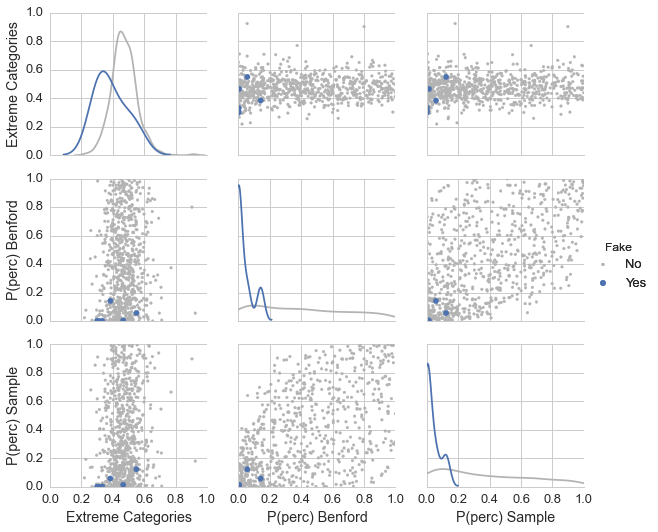

In [251]:
g = sns.pairplot(train_combined, vars=['Extreme Categories','P(perc) Benford', 'P(perc) Sample'], hue="Fake",
                 palette=pal, \
                 diag_kind="kde", size=2.5, plot_kws={'s':[30,30,30], 'edgecolor':'grey'},
                markers=['.','o'])
g.add_legend()
g.set(ylim=(0, 1), xlim=(0,1));

### Synthetic sampling

In [ ]:
features = train_combined[['Extreme Categories','Chi2 Benford', 'Chi2 Sample']].values
labels = train_combined['target'].values

pd.value_counts(labels)

In [ ]:
# 'SMOTE ENN'
SENN = unbalanced_dataset.SMOTEENN(ratio=15,k=5, verbose=True)
ennx, enny = SENN.fit_transform(features, labels)

In [253]:
oversample = pd.DataFrame(ennx)
oversample['fake'] = enny 
oversample.rename(columns={0: 'Extreme Categories', 1: 'P(perc) Benford', \
                   2:'P(perc) Sample', 'fake': 'Fake'}, inplace=True)
oversample['target'] = oversample['Fake']
oversample['Fake'] = oversample['Fake'].map({0: 'No', 1: 'Yes'})

In [97]:
pd.value_counts(oversample['Fake'])

No     696
Yes     71
dtype: int64

In [157]:
print(71/696)

0.10201149425287356


#### Synthetic sample pairplot

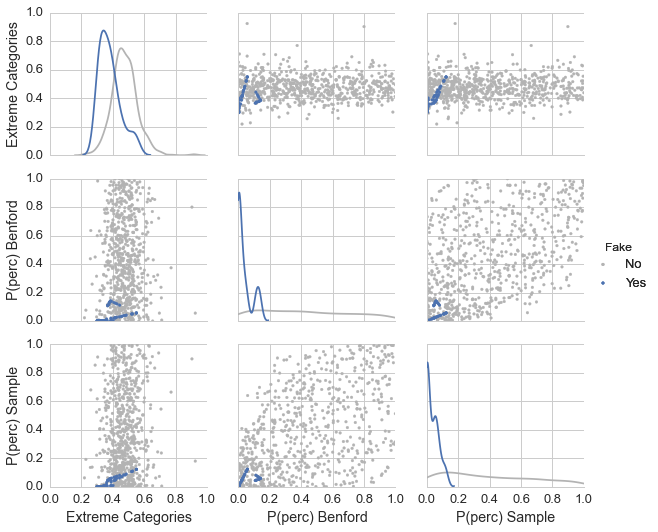

In [254]:
g = sns.pairplot(oversample, vars=['Extreme Categories','P(perc) Benford', 'P(perc) Sample'], hue="Fake", \
                 palette=pal, diag_kind="kde", size=2.5, plot_kws={'s':[30,30,30], 'edgecolor':'grey'},
                markers=['.','.'])
g.add_legend()
g.set(ylim=(0, 1), xlim=(0,1));

#### Synthetic sample Kernel Density

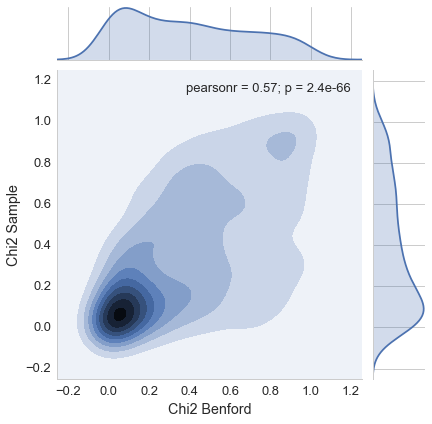

In [194]:
sns.jointplot(x="Chi2 Benford", y="Chi2 Sample", data=oversample, kind="kde")

In [ ]:
oversample.to_pickle('oversample')

with open('ennx', 'wb') as fp:
    pickle.dump(ennx, fp)
    
with open('enny', 'wb') as fp:
    pickle.dump(enny, fp)    

### Model Fitting

*Note that the use of unsupervised methods was tested exhaustively but not included in this document.*

In [252]:
oversample = pd.read_pickle('oversample')

with open('ennx', 'rb') as fp:
    ennx = pickle.load(fp)
    
with open('enny', 'rb') as fp:
    enny = pickle.load(fp) 

#### Training Model on Oversample Data

##### Support Vector Machine (not included in the paper)

In [935]:
# Parameter Grid

param_svc = [
  
  {'C': [0.8, 0.9, 1.0], 'kernel': ['linear', 'rbf'], 'class_weight':  ['auto', {0:1, 1:3}], 
  'probability':[True]}, 
 ]

clf = GridSearchCV(SVC(), param_svc, scoring='f1_weighted', cv=10)

In [936]:
# Scaling Features
scaler = MinMaxScaler()
ennx_s = scaler.fit(ennx).transform(ennx)

In [937]:
# Fitting Model
clf = clf.fit(ennx_s, enny)

In [938]:
# Weighted F1-Score for Cross Validation Grid Search
clf.best_score_

0.93787651023202145

In [929]:
clf.best_estimator_

SVC(C=0.9, cache_size=200, class_weight={0: 1, 1: 3}, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [930]:
model = clf.best_estimator_
svm = model.fit(ennx_s, enny)

##### Logistic Regression

In [213]:
# Parameter Grid
param_logit={'class_weight':  ['auto',  {0:1, 1:3}], 
            'fit_intercept':[True,False],
             'solver':('newton-cg', 'lbfgs', 'liblinear',),
                      'penalty':['l1', 'l2'],
             'C':[0.8, 0.9, 1.0]
           }

clf = GridSearchCV(LogisticRegression(), param_logit, scoring='f1_weighted', cv = 5)

In [214]:
# Fitting Model
clf = clf.fit(ennx, enny)

In [215]:
# Weighted F1-Score for Cross Validation Grid Search
clf.best_score_

0.93187042496030803

In [216]:
clf.best_estimator_

LogisticRegression(C=0.8, class_weight={0: 1, 1: 3}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [217]:
model = clf.best_estimator_
logit = model.fit(ennx, enny)

### Predicting probabilities for 1999 and 2000

#### 1999

In [219]:
d99_features = d99_combined[['extreme', 'chi2_boot',  'chi2_sv']].values
d99_labels = d99_combined['fake'].values

In [227]:
probs = logit.predict_proba(d99_features)
d99_combined['probs'] = probs[:,1]
d99_results = d99_combined.sort('probs', ascending=False)[['sum','extreme', 'chi2_boot', 'chi2_sv', 'probs']]
d99_results.head(20)

,sum,extreme,chi2_boot,chi2_sv,probs
249289,71,0.218150,0.0005,0.0000,0.796313
1003367,66,0.314696,0.0005,0.0010,0.739960
1002565,118,0.297770,0.0135,0.0000,0.738169
1001171,38,0.317459,0.0005,0.0065,0.732720
1003554,124,0.335859,0.0000,0.0005,0.727605
1001990,56,0.340380,0.0000,0.0000,0.725209
1004013,61,0.329230,0.0085,0.0035,0.719751
1002487,12,0.355601,0.0005,0.0000,0.714741
1004296,6,0.351852,0.0070,0.0020,0.708008
1003696,44,0.342891,0.0005,0.0150,0.707305


In [ ]:
#converting to latex table
print(d99_results.head(20).to_latex())

#### 2000

In [222]:
d2k_features = d2k_combined[['extreme','chi2_boot',  'chi2_sv']].values
d2k_features2 = d2k_combined[['chi2_boot',  'chi2_sv']].values
d2k_labels = d2k_combined['fake'].values

In [229]:
probs = logit.predict_proba(d2k_features)
d2k_combined['probs'] = probs[:,1]
d2k_results = d2k_combined.sort('probs', ascending=False)[['sum','extreme', 'chi2_boot', 'chi2_sv', 'probs']]
d2k_results.head(20)

,sum,extreme,chi2_boot,chi2_sv,probs
270857,43,0.108766,0.0000,0.0000,0.848144
1004079,60,0.193407,0.0070,0.0000,0.803589
1001131,17,0.214844,0.0015,0.0000,0.797184
1003533,9,0.227893,0.0000,0.0000,0.791590
1002704,42,0.241121,0.0005,0.0020,0.782237
1002751,130,0.254981,0.0000,0.0000,0.776756
1004307,3,0.256494,0.0000,0.0000,0.775906
1004204,5,0.107143,0.0250,0.0695,0.774510
1002421,144,0.261996,0.0000,0.0000,0.772794
1004293,56,0.264813,0.0000,0.0000,0.771189


In [ ]:
# converting to latex table
print(d2k_results.head(20).to_latex())

### Misc

##### 3d plot of features in the 98 E sample (not included in the paper)

In [89]:
plot_fake2 = d98_schraepler[d98_schraepler.fake==1][['extreme', 'chi2_boot', 'chi2_sv']]
plot_nofake2 = d98_schraepler[d98_schraepler.fake==0][['extreme', 'chi2_boot', 'chi2_sv']]

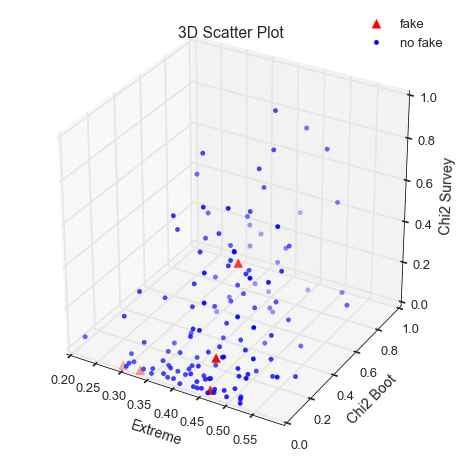

In [90]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
   
ax.scatter(plot_fake2['extreme'], plot_fake2['chi2_boot'], plot_fake2['chi2_sv'], 
           marker='^', color='red', s=80, label='fake')
ax.scatter(plot_nofake2['extreme'], plot_nofake2['chi2_boot'], plot_nofake2['chi2_sv'], 
           marker='o', color='blue', s=20, label='no fake')

ax.set_xlabel('Extreme')
ax.set_ylabel('Chi2 Boot')
ax.set_zlabel('Chi2 Survey')

ax.set_xlim3d(0.2, 0.6)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)

plt.title('3D Scatter Plot')
plt.legend()   
plt.show()

----

```feel free to contact me: carsten.schwemmer@methodds.de```